In [ ]:
!pip install pydicom rdflib networkx matplotlib

In [1]:
import pydicom
from pathlib import Path
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import uuid

In [2]:
# Set directory with DICOM files
dicom_dir = Path("dicom_files")

In [3]:
# Define namespaces
EX = Namespace("http://example.org/ro/")
DCAT = Namespace("http://www.w3.org/ns/dcat#")
DCT = Namespace("http://purl.org/dc/terms/")
FOAF = Namespace("http://xmlns.com/foaf/0.1/")

In [4]:
# Create the RDF Graph
g = Graph()
g.bind("ex", EX)
g.bind("dcat", DCAT)
g.bind("dct", DCT)
g.bind("foaf", FOAF)

In [5]:
# Iterate through all .dcm files in the folder
for dicom_file in dicom_dir.glob("*.dcm"):
    ds = pydicom.dcmread(dicom_file)

    # Extract metadata safely
    metadata = {
        "PatientName": str(ds.get("PatientName", "Unknown")),
        "PatientID": str(ds.get("PatientID", "Unknown")),
        "Modality": str(ds.get("Modality", "Unknown")),
        "StudyDate": str(ds.get("StudyDate", "Unknown")),
        "SeriesDescription": str(ds.get("SeriesDescription", "Unknown")),
        "InstitutionName": str(ds.get("InstitutionName", "Unknown")),
    }

    # Generate a unique URI for each dataset
    dataset_uri = EX[f"dicom_{uuid.uuid4().hex}"]
    g.add((dataset_uri, RDF.type, DCAT.Dataset))

    # Add RDF triples
    g.add((dataset_uri, DCT.title, Literal(metadata["SeriesDescription"])))
    g.add((dataset_uri, DCT.creator, Literal(metadata["InstitutionName"])))
    g.add((dataset_uri, DCT.date, Literal(metadata["StudyDate"])))
    g.add((dataset_uri, DCT.identifier, Literal(metadata["PatientID"])))
    g.add((dataset_uri, DCT.description, Literal(f"Modality: {metadata['Modality']}")))
    g.add((dataset_uri, FOAF.name, Literal(metadata["PatientName"])))

In [6]:
print(g.serialize(format="turtle"))

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/ro/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .

ex:dicom_019a1a5d2ab84daa8e7f4337390f8477 a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "20250807" ;
    dct:description "Modality: OT" ;
    dct:identifier "PAT013" ;
    dct:title "Unknown" ;
    foaf:name "Patient^PAT013" .

ex:dicom_04d66d1425dd4693bf7a089813f33875 a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "20250807" ;
    dct:description "Modality: OT" ;
    dct:identifier "PAT041" ;
    dct:title "Unknown" ;
    foaf:name "Patient^PAT041" .

ex:dicom_0552f7822b404af2ae150719fc487eba a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "20250807" ;
    dct:description "Modality: OT" ;
    dct:identifier "PAT040" ;
    dct:title "Unknown" ;
    foaf:name "Patient^PAT040" .

ex:dicom_06bf5e50d24845078f2cae64f5c3cbde a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "202508

Visualize Combined Knowledge Graph

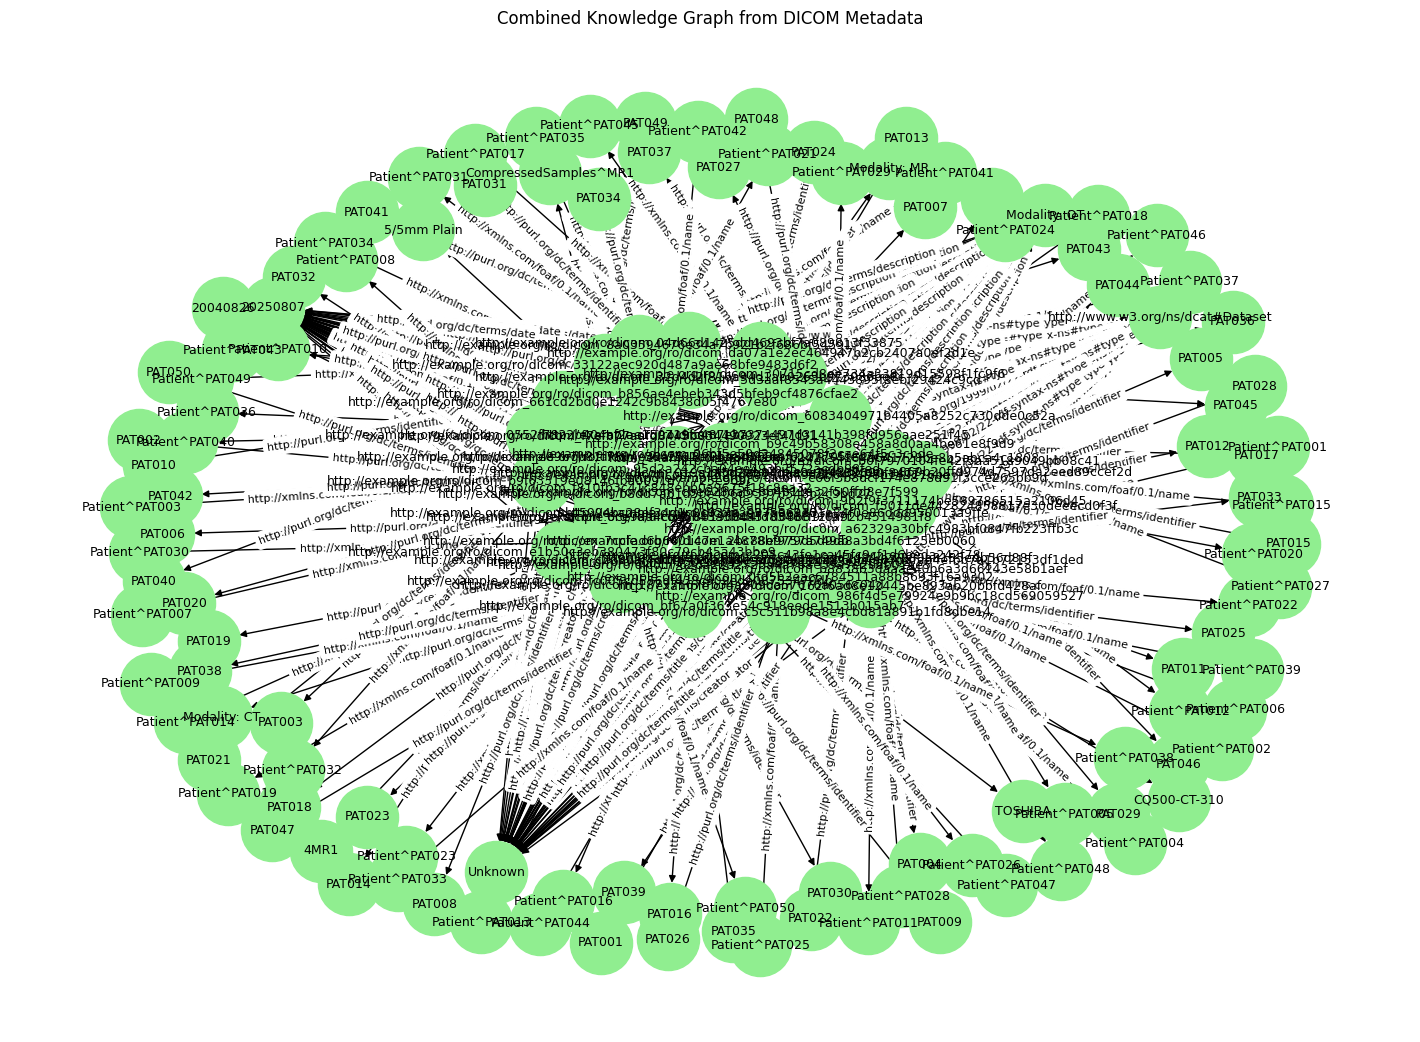

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert RDF to NetworkX graph
G = nx.DiGraph()
for s, p, o in g:
    G.add_edge(str(s), str(o), label=str(p))

# Draw
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.6)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightgreen", font_size=9)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Combined Knowledge Graph from DICOM Metadata")
plt.show()

In [8]:
from datetime import datetime

# --- Step 1: Define the Catalog URI ---
catalog_uri = EX["dicom_catalog"]

# Add Catalog metadata
g.add((catalog_uri, RDF.type, DCAT.Catalog))
g.add((catalog_uri, DCT.title, Literal("DICOM Metadata Catalog")))
g.add((catalog_uri, DCT.description, Literal("A catalog of DICOM metadata extracted from medical imaging files.")))
g.add((catalog_uri, DCT.issued, Literal(datetime.now().date())))
g.add((catalog_uri, DCT.creator, Literal("Your Lab / Hospital / Org")))

# --- Step 2: Link All Datasets to Catalog ---
for s, p, o in g.triples((None, RDF.type, DCAT.Dataset)):
    g.add((catalog_uri, DCAT.dataset, s))

In [9]:
print(g.serialize(format="turtle"))

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/ro/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:dicom_catalog a dcat:Catalog ;
    dct:creator "Your Lab / Hospital / Org" ;
    dct:description "A catalog of DICOM metadata extracted from medical imaging files." ;
    dct:issued "2025-08-07"^^xsd:date ;
    dct:title "DICOM Metadata Catalog" ;
    dcat:dataset ex:dicom_019a1a5d2ab84daa8e7f4337390f8477,
        ex:dicom_04d66d1425dd4693bf7a089813f33875,
        ex:dicom_0552f7822b404af2ae150719fc487eba,
        ex:dicom_06bf5e50d24845078f2cae64f5c3cbde,
        ex:dicom_0fd5b2eac6784511a88b8693f16a9302,
        ex:dicom_137374497d3141b398fd956aae251f45,
        ex:dicom_162f6ad8e12445be893ab20bbfd428af,
        ex:dicom_18737167ffb34a309da57676a056c04d,
        ex:dicom_2bc88e9757a749a8a3bd4f6125eb0060,
        ex:dicom_30715cd8ee734a33819d15598f1fc9f6,
      

In [10]:
print(g.serialize(format="json-ld", indent=2))

[
  {
    "@id": "http://example.org/ro/dicom_e89b7b81f7804e30af291bf9ba8d109e",
    "@type": [
      "http://www.w3.org/ns/dcat#Dataset"
    ],
    "http://purl.org/dc/terms/creator": [
      {
        "@value": "Unknown"
      }
    ],
    "http://purl.org/dc/terms/date": [
      {
        "@value": "20250807"
      }
    ],
    "http://purl.org/dc/terms/description": [
      {
        "@value": "Modality: OT"
      }
    ],
    "http://purl.org/dc/terms/identifier": [
      {
        "@value": "PAT032"
      }
    ],
    "http://purl.org/dc/terms/title": [
      {
        "@value": "Unknown"
      }
    ],
    "http://xmlns.com/foaf/0.1/name": [
      {
        "@value": "Patient^PAT032"
      }
    ]
  },
  {
    "@id": "http://example.org/ro/dicom_725bcccb99c54085b124445ec4cbcf02",
    "@type": [
      "http://www.w3.org/ns/dcat#Dataset"
    ],
    "http://purl.org/dc/terms/creator": [
      {
        "@value": "Unknown"
      }
    ],
    "http://purl.org/dc/terms/date": [
      

In [11]:
import pandas as pd

datasets = []

for dataset_uri in g.subjects(RDF.type, DCAT.Dataset):
    entry = {
        "URI": str(dataset_uri),
        "Title": str(g.value(dataset_uri, DCT.title, default="")),
        "Date": str(g.value(dataset_uri, DCT.date, default="")),
        "Patient ID": str(g.value(dataset_uri, DCT.identifier, default="")),
        "Institution": str(g.value(dataset_uri, DCT.creator, default="")),
        "Modality": str(g.value(dataset_uri, DCT.description, default="")),
        "Patient Name": str(g.value(dataset_uri, FOAF.name, default="")),
    }
    datasets.append(entry)

df = pd.DataFrame(datasets)
df.head()

,URI,Title,Date,Patient ID,Institution,Modality,Patient Name
0,http://example.org/ro/dicom_06bf5e50d24845078f...,Unknown,20250807,PAT020,Unknown,Modality: OT,Patient^PAT020
1,http://example.org/ro/dicom_661cd2bd0e1242c9b8...,Unknown,20250807,PAT010,Unknown,Modality: OT,Patient^PAT010
2,http://example.org/ro/dicom_e869b20ffd974d7597...,Unknown,20250807,PAT015,Unknown,Modality: OT,Patient^PAT015
3,http://example.org/ro/dicom_c66f3b8dcf174e878d...,Unknown,20250807,PAT029,Unknown,Modality: OT,Patient^PAT029
4,http://example.org/ro/dicom_04d66d1425dd4693bf...,Unknown,20250807,PAT041,Unknown,Modality: OT,Patient^PAT041


In [12]:
from datetime import datetime

# Create timestamp in format: YYYYMMDD_HHMMSS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename with timestamp
filename = f"dcat_catalog_{timestamp}.ttl"

# Save RDF graph in Turtle format
with open(filename, "w") as f:
    f.write(g.serialize(format="turtle"))

print(f"Saved DCAT catalog to: {filename}")

Saved DCAT catalog to: dcat_catalog_20250807_143818.ttl
